In [41]:
import os
import re
import pandas as pd
import numpy as np
import struct
from datetime import datetime, timedelta
from pathlib import Path
from typing import List, Optional, Tuple
from dataclasses import dataclass

@dataclass
class TDFRampRecord:
    timestamp: datetime
    station_id: int
    ramp_controller:  int
    ramp_rate:  float
    ramp_start_freq: float
    transmitter_freq: float
    uplink_band: int
    spacecraft_id: int

class TDFParser:
    RECORD_SIZE = 288
    DATA_TYPE_RAMP = 6

    def __init__(self, verbose=True):
        self.verbose = verbose
        self.records = []

    def parse(self, filepath: str) -> pd.DataFrame:
        filepath = Path(filepath)

        if not filepath.exists():
            if self.verbose:
                print(f" Файл не найден: {filepath}")
            return pd.DataFrame()

        filesize = os.path.getsize(filepath)
        num_records = filesize // self.RECORD_SIZE

        if self.verbose:
            print(f"    TDF:  {filepath.name} ({num_records:,} records)")

        self.records = []

        with open(filepath, 'rb') as f:
            for _ in range(num_records):
                data = f.read(self.RECORD_SIZE)
                if len(data) < self.RECORD_SIZE:
                    break
                record = self._parse_record(data)
                if record:
                    self.records.append(record)

        if self.verbose:
            print(f"       RAMP записей:  {len(self.records)}")

        return self._to_dataframe()

    def _parse_record(self, data: bytes) -> Optional[TDFRampRecord]:
        record_type = struct.unpack('>I', data[5:9])[0]
        if record_type not in (90, 91):
            return None

        dtb1 = struct.unpack('>I', data[18:22])[0]
        data_type = (dtb1 >> 8) & 0x3F

        if data_type != self.DATA_TYPE_RAMP: 
            return None

        timestamp = self._parse_datetime(data[9:18])
        if timestamp is None:
            return None

        station_id = (dtb1 >> 22) & 0x3FF
        spacecraft_id = struct.unpack('>H', data[22:24])[0]
        uplink_band = data[180]

        ramp_controller = data[225]
        ramp_rate_hp = struct.unpack('>i', data[226:230])[0]
        ramp_rate_lp = struct.unpack('>i', data[230:234])[0]
        ramp_rate = ramp_rate_hp * 1e3 + ramp_rate_lp * 1e-6

        val = int.from_bytes(data[234:239], 'big')
        ramp_start_hp = (val >> 4) & 0xFFFFFFFF
        val2 = int.from_bytes(data[238:243], 'big')
        ramp_start_lp = (val2 >> 4) & 0xFFFFFFFF
        ramp_start_freq = ramp_start_hp * 1e3 + ramp_start_lp * 1e-6

        change_block = data[243:252]
        val = int.from_bytes(change_block, 'big')
        tx_hp = (val >> 30) & 0x0FFFFFFF
        tx_lp = val & 0x3FFFFFFF
        transmitter_freq = tx_hp * 1e3 + tx_lp * 1e-6

        return TDFRampRecord(
            timestamp=timestamp,
            station_id=station_id,
            ramp_controller=ramp_controller,
            ramp_rate=ramp_rate,
            ramp_start_freq=ramp_start_freq,
            transmitter_freq=transmitter_freq,
            uplink_band=uplink_band,
            spacecraft_id=spacecraft_id
        )

    def _parse_datetime(self, data:  bytes) -> Optional[datetime]:
        val = int.from_bytes(data[0:7], 'big')
        year_mod = (val >> 44) & 0xFFF
        doy = (val >> 28) & 0xFFFF
        hour = (val >> 20) & 0xFF
        minute = (val >> 12) & 0xFF
        second = (val >> 4) & 0xFF

        year = 1900 + year_mod if year_mod >= 50 else 2000 + year_mod

        if doy == 0 or doy > 366:
            return None

        try:
            base_date = datetime(year, 1, 1)
            return base_date + timedelta(days=doy-1, hours=hour, 
                                         minutes=minute, seconds=second)
        except: 
            return None

    def _to_dataframe(self) -> pd.DataFrame:
        if not self.records:
            return pd.DataFrame()

        data = []
        for r in self.records:
            ctrl_name = {0: 'POCA', 1: 'DCO', 4: 'BlockV'}.get(r.ramp_controller, f'Unknown')
            data.append({
                'ramp_datetime_utc': r.timestamp,
                'ramp_station_id': r.station_id,
                'ramp_controller':  r.ramp_controller,
                'ramp_controller_name': ctrl_name,
                'ramp_rate_hz_s': r.ramp_rate,
                'ramp_start_freq_hz': r.ramp_start_freq,
                'ramp_start_freq_ghz': r.ramp_start_freq / 1e9,
                'uplink_band': r.uplink_band,
                'spacecraft_id': r.spacecraft_id
            })

        return pd.DataFrame(data)

class MGSCombinedParser:
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.epoch_1950 = datetime(1950, 1, 1, 0, 0, 0)
        self.doppler_data:  Optional[pd.DataFrame] = None
        self.ramp_data: Optional[pd.DataFrame] = None

    def parse_tdf_folder(self, tdf_folder: str) -> pd.DataFrame:
        folder = Path(tdf_folder)
        tdf_files = sorted(list(folder.glob("*.tdf")) + list(folder.glob("*.TDF")))

        if not tdf_files: 
            if self.verbose:
                print(" TDF файлы не найдены")
            return pd.DataFrame()

        if self.verbose:
            print(f"\n{'='*60}")
            print(f" ПАРСИНГ TDF ФАЙЛОВ (RAMP)")
            print(f"{'='*60}")
            print(f"   Найдено файлов: {len(tdf_files)}")

        all_ramp = []
        tdf_parser = TDFParser(verbose=self.verbose)

        for tdf_file in tdf_files:
            df = tdf_parser.parse(str(tdf_file))
            if not df.empty:
                df['tdf_source_file'] = tdf_file.name
                all_ramp.append(df)

        if all_ramp: 
            self.ramp_data = pd.concat(all_ramp, ignore_index=True)
            self.ramp_data = self.ramp_data.sort_values('ramp_datetime_utc').reset_index(drop=True)
            self.ramp_data = self._clean_ramp_data(self.ramp_data)

            if self.verbose:
                print(f"\n    ИТОГО RAMP:")
                print(f"      Записей: {len(self.ramp_data):,}")
                print(f"      Период: {self.ramp_data['ramp_datetime_utc'].min()} — {self.ramp_data['ramp_datetime_utc'].max()}")
                print(f"      Станции: DSS-{', DSS-'.join(map(str, sorted(self.ramp_data['ramp_station_id'].unique())))}")

        return self.ramp_data if self.ramp_data is not None else pd.DataFrame()

    def _clean_ramp_data(self, df: pd.DataFrame, max_ramp_rate: float = 20.0) -> pd.DataFrame:
        original = len(df)
        df_clean = df[abs(df['ramp_rate_hz_s']) <= max_ramp_rate].copy()
        removed = original - len(df_clean)

        if self.verbose and removed > 0:
            print(f"       Удалено аномалий: {removed} (|rate| > {max_ramp_rate} Hz/s)")

        return df_clean

    def parse_odf_folder(self, odf_folder: str, 
                         date_filter: Optional[Tuple[int, int]] = None,
                         hour_start_first_day: Optional[int] = None,
                         minute_start_first_hour: Optional[int] = None) -> pd.DataFrame:
        folder = Path(odf_folder)
        lbl_files = sorted(list(folder.glob("*.lbl")) + list(folder.glob("*.LBL")))
        if not lbl_files: 
            if self.verbose:
                print(" LBL файлы не найдены")
            return pd.DataFrame()
        if self.verbose:
            print(f"\n{'='*60}")
            print(f" ПАРСИНГ ODF ФАЙЛОВ (DOPPLER)")
            print(f"{'='*60}")
            print(f"   Найдено LBL файлов: {len(lbl_files)}")
        all_doppler = []
        for lbl_file in lbl_files:
            tables = self._parse_lbl_file(lbl_file)
            for table_name, table_info in tables.items():
                if 'ODF3C' not in table_name.upper():
                    continue
                odf_path = self._find_odf_file(odf_folder, table_info['odf_file'])
                if not odf_path: 
                    continue
                df = self._parse_odf3c_table(
                    odf_path, 
                    table_info['start_record'],
                    table_info.get('record_bytes', 36),
                    date_filter=date_filter,
                    hour_start_first_day=hour_start_first_day,
                    minute_start_first_hour=minute_start_first_hour
                )
                if not df.empty:
                    df['lbl_file'] = lbl_file.name
                    all_doppler.append(df)
        if all_doppler:
            self.doppler_data = pd.concat(all_doppler, ignore_index=True)
            self.doppler_data = self.doppler_data.sort_values('datetime_utc').reset_index(drop=True)
            if self.verbose:
                print(f"\n    ИТОГО DOPPLER:")
                print(f"      Записей: {len(self.doppler_data):,}")
                print(f"      Период:  {self.doppler_data['datetime_utc'].min()} — {self.doppler_data['datetime_utc'].max()}")
                print(f"      Станции: DSS-{', DSS-'.join(map(str, sorted(self.doppler_data['receiving_station_id'].unique())))}")
        return self.doppler_data if self.doppler_data is not None else pd.DataFrame()

    def _parse_lbl_file(self, lbl_path: Path) -> dict:
        tables = {}
        try:
            with open(lbl_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            pattern = r'^\^(\w+)\s*=\s*\(\s*"([^"]+)",\s*(\d+)\s*\)'
            matches = re.findall(pattern, content, re.MULTILINE)
            for table_name, odf_file, start_record in matches: 
                rb_pattern = rf'{re.escape(table_name)}\.RECORD_BYTES\s*=\s*(\d+)'
                rb_match = re.search(rb_pattern, content)
                record_bytes = int(rb_match.group(1)) if rb_match else 36
                tables[table_name] = {
                    'odf_file': odf_file,
                    'start_record': int(start_record),
                    'record_bytes': record_bytes
                }
            if self.verbose:
                print(f"    {lbl_path.name}:  {len(tables)} таблиц")
        except Exception as e:
            print(f"    Ошибка LBL {lbl_path.name}: {e}")
        return tables

    def _find_odf_file(self, folder_path: str, odf_filename: str) -> Optional[Path]:
        folder = Path(folder_path)
        for file in folder.iterdir():
            if file.name.upper() == odf_filename.upper():
                return file
        return None

    def _parse_odf3c_table(self, odf_path:  Path, start_record: int, 
                           record_size: int = 36, max_records: int = None,
                           date_filter: Optional[Tuple[int, int]] = None,
                           hour_start_first_day: Optional[int] = None,
                           minute_start_first_hour: Optional[int] = None) -> pd.DataFrame:
        records = []
        try:
            with open(odf_path, 'rb') as f:
                f.seek((start_record - 1) * record_size)
                records_read = 0
                while True: 
                    if max_records and len(records) >= max_records:
                        break
                    chunk = f.read(record_size)
                    if not chunk or len(chunk) < record_size: 
                        break
                    record = self._parse_odf3c_record(chunk, date_filter, hour_start_first_day, minute_start_first_hour)
                    if record: 
                        record['source_file'] = odf_path.name
                        records.append(record)
                    records_read += 1
                if self.verbose and records: 
                    print(f"       {odf_path.name}: {len(records)} записей")
        except Exception as e:
            print(f"       Ошибка {odf_path.name}: {e}")
        return pd.DataFrame(records)

    def _parse_odf3c_record(self, chunk: bytes, 
                            date_filter: Optional[Tuple[int, int]] = None,
                            hour_start_first_day: Optional[int] = None,
                            minute_start_first_hour: Optional[int] = None) -> Optional[dict]:
        if len(chunk) < 36:
            return None
        try:
            time_int = struct.unpack('>I', chunk[0:4])[0]
            time_frac = struct.unpack('>I', chunk[4:8])[0]
            obs_int = struct.unpack('>i', chunk[8:12])[0]
            obs_frac = struct.unpack('>I', chunk[12:16])[0]
            if time_int < 1000000:
                return None
            bits_value = struct.unpack('>I', chunk[16:20])[0]
            data_type_id = (bits_value >> 7) & 0x3F
            if data_type_id != 12:
                return None
            doppler_hz = obs_int + obs_frac / 2**32
            if abs(doppler_hz) > 100000:
                return None
            total_seconds = time_int + time_frac / 2**32
            utc_time = self.epoch_1950 + timedelta(seconds=total_seconds)
            if date_filter:
                day_start, day_end = date_filter
                if not (day_start <= utc_time.day <= day_end):
                    return None
                if hour_start_first_day:
                    if utc_time.day == date_filter[0]:
                        if utc_time.hour < hour_start_first_day:
                            return None
                        elif utc_time.hour == hour_start_first_day and minute_start_first_hour:
                            if utc_time.minute < minute_start_first_hour:
                                return None
            ref_freq_mhz = 0

            if len(chunk) >= 28:
                ref_part = struct.unpack('>I', chunk[20:24])[0]
                ref_freq_mhz = ref_part / 1000.0

            # Compression time — float32 big endian, байты 28-32
            compression_time = None
            if len(chunk) >= 32:
                # Читаем как uint32 (беззнаковое целое) из байтов 28:32
                compression_time_raw = struct.unpack('>I', chunk[28:32])[0]
                # Теперь compression_time_raw = 5
                # Далее нужно понять единицы измерения. Скорее всего, это секунды.
                compression_time = float(compression_time_raw) 

            return {
                'datetime_utc': utc_time,
                'time_tag_seconds': total_seconds,
                'doppler_hz': doppler_hz,
                'data_type_id':  data_type_id,
                'receiving_station_id':  (bits_value >> 22) & 0x7F,
                'transmitting_station_id':  (bits_value >> 15) & 0x7F,
                'ref_freq_mhz': ref_freq_mhz,
                'compression_time': compression_time,
            }
        except: 
            return None

    def parse_all(self, odf_folder: str, tdf_folder: str = None,
                  date_filter: Optional[Tuple[int, int]] = None,
                  hour_start_first_day: Optional[int] = None,
                  minute_start_first_hour: Optional[int] = None,
                  output_file: str = None,
                  ramp_output_file: str = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
        if tdf_folder is None:
            tdf_folder = odf_folder
        print("\n" + "="*70)
        print(" MGS COMBINED PARSER:  ODF + LBL + TDF")
        print("="*70)
        # 1. Парсим TDF (RAMP)
        ramp_df = self.parse_tdf_folder(tdf_folder)
        # 2. Парсим ODF (Doppler)
        doppler_df = self.parse_odf_folder(odf_folder, date_filter, hour_start_first_day, minute_start_first_hour)
        # 3. Сохраняем их РАЗДЕЛЬНО
        if output_file and doppler_df is not None and not doppler_df.empty:
            doppler_df.to_csv(output_file, index=False)
            print(f"\n Сохранено:  {output_file}")
        if ramp_output_file and ramp_df is not None and not ramp_df.empty:
            ramp_df.to_csv(ramp_output_file, index=False)
            print(f" RAMP данные:  {ramp_output_file}")
        print("\n" + "="*70)
        print(" ПАРСИНГ ЗАВЕРШЁН")
        print("="*70)
        return doppler_df, ramp_df

print("MGSCombinedParser загружен!")

MGSCombinedParser загружен!


Запуск парсинга и проверка данных

In [42]:
parser = MGSCombinedParser(verbose=True)

ODF_FOLDER = "input_data"        # ODF и LBL файлы
TDF_FOLDER = "input_data"        # TDF файлы (можно ту же папку)
OUTPUT_FILE = "output_data/mgs_doppler.csv"
RAMP_FILE = "output_data/mgs_ramp.csv"

doppler_df, ramp_df = parser.parse_all(
    odf_folder=ODF_FOLDER,
    tdf_folder=TDF_FOLDER,
    date_filter=(19, 20),
    hour_start_first_day=0,
    minute_start_first_hour=30,
    output_file=OUTPUT_FILE,
    ramp_output_file=RAMP_FILE
)

print(f"\nИтоговый DataFrame (doppler):  {len(doppler_df)} записей")
print(f"Итоговый DataFrame (ramp):     {len(ramp_df)} записей")

if len(doppler_df) > 0:
    print("\nПо станциям:")
    print(doppler_df.groupby('receiving_station_id').agg({
        'doppler_hz': ['count', 'mean', 'std'],
    }).round(3))

    print(f"\nПериод Doppler: {doppler_df['datetime_utc'].min()} — {doppler_df['datetime_utc'].max()}")
if len(ramp_df) > 0:
    print(f"Период RAMP:     {ramp_df['ramp_datetime_utc'].min()} — {ramp_df['ramp_datetime_utc'].max()}")


 MGS COMBINED PARSER:  ODF + LBL + TDF

 ПАРСИНГ TDF ФАЙЛОВ (RAMP)
   Найдено файлов: 5
    TDF:  7258260a.tdf (135,352 records)
       RAMP записей:  161
    TDF:  7260261a.tdf (136,668 records)
       RAMP записей:  106
    TDF:  7261262a.tdf (136,164 records)
       RAMP записей:  166
    TDF:  7262263a.tdf (135,884 records)
       RAMP записей:  128
    TDF:  7263265a.tdf (136,640 records)
       RAMP записей:  146
       Удалено аномалий: 105 (|rate| > 20.0 Hz/s)

    ИТОГО RAMP:
      Записей: 602
      Период: 1997-09-15 19:40:35 — 1997-09-22 11:34:54
      Станции: DSS-15, DSS-24, DSS-25, DSS-45, DSS-54, DSS-65

 ПАРСИНГ ODF ФАЙЛОВ (DOPPLER)
   Найдено LBL файлов: 11
    7258260a.lbl:  4 таблиц
    7260261a.lbl:  4 таблиц
    7261262a.lbl:  18 таблиц
       7261262a.odf: 356 записей
    7262262a.lbl:  16 таблиц
       7262262a.odf: 311 записей
    7262262b.lbl:  16 таблиц
       7262262b.odf: 120 записей
    7262262c.lbl:  14 таблиц
       7262262c.odf: 139 записей
    7262263

Визуализация

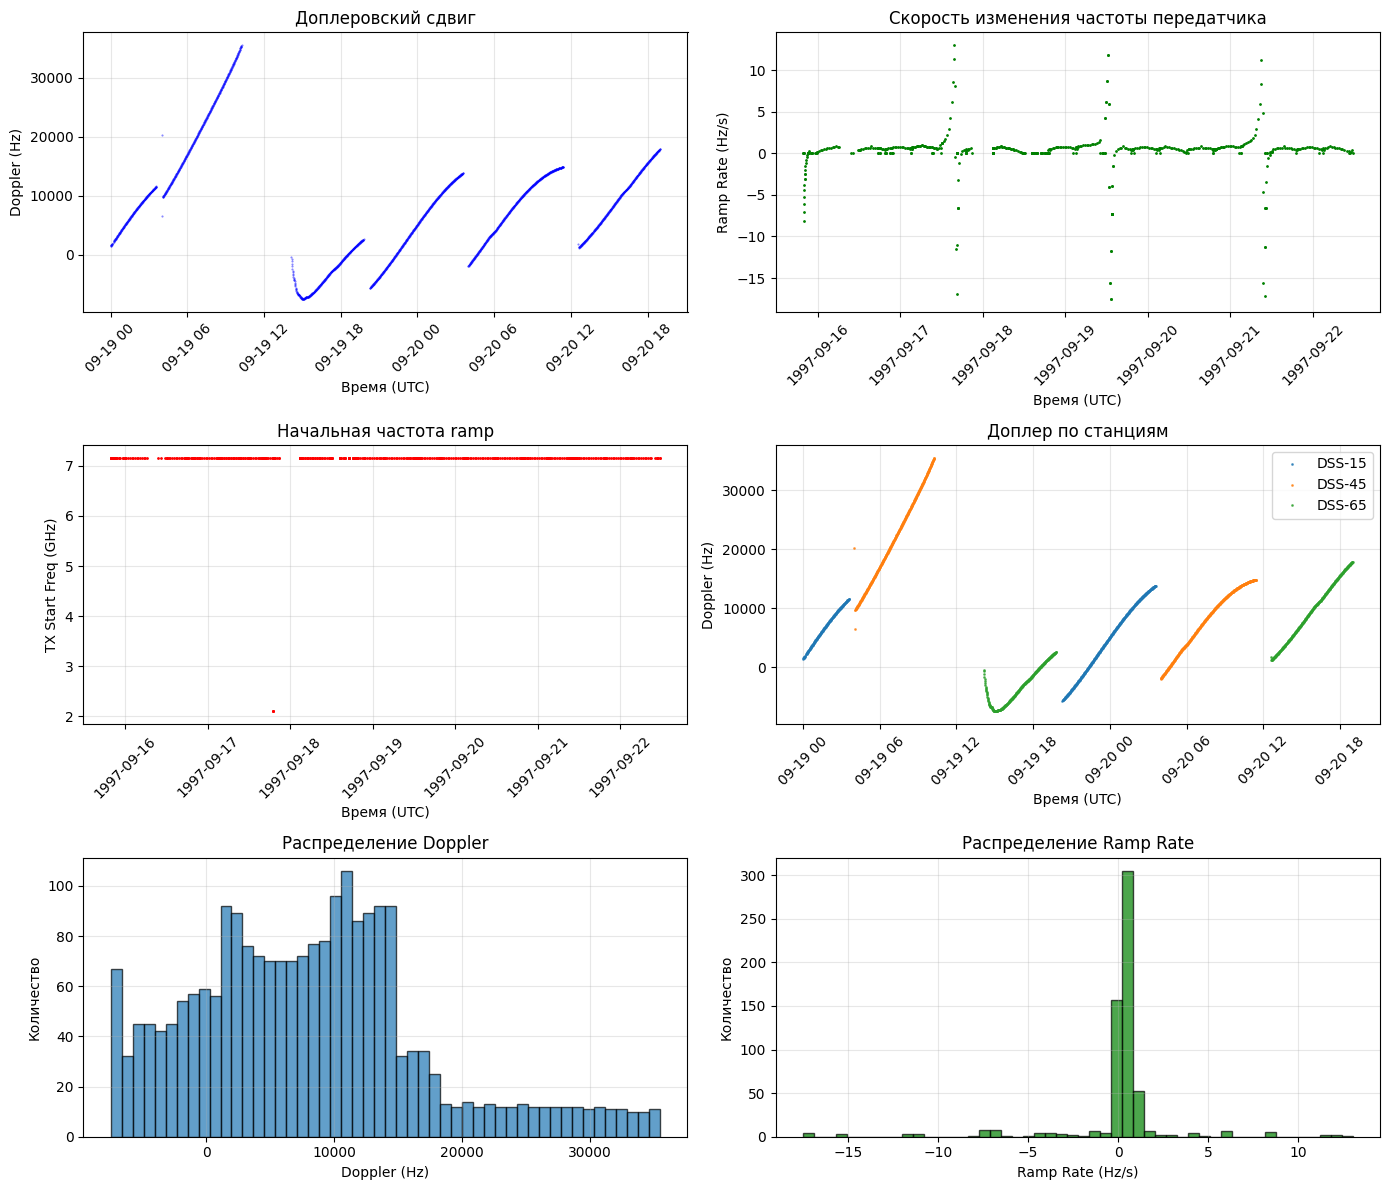

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Загружаем выходные таблицы ---
doppler_df = pd.read_csv('output_data/mgs_doppler.csv', parse_dates=['datetime_utc'])
ramp_df = pd.read_csv('output_data/mgs_ramp.csv', parse_dates=['ramp_datetime_utc'])

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 1. Доплер во времени
ax = axes[0, 0]
ax.plot(doppler_df['datetime_utc'], doppler_df['doppler_hz'],
        'b.', markersize=1, alpha=0.5)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('Doppler (Hz)')
ax.set_title('Доплеровский сдвиг')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 2. Ramp Rate во времени (теперь из ramp_df)
ax = axes[0, 1]
ax.plot(ramp_df['ramp_datetime_utc'], ramp_df['ramp_rate_hz_s'],
        'g.', markersize=2)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('Ramp Rate (Hz/s)')
ax.set_title('Скорость изменения частоты передатчика')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 3. Абсолютная ramp-частота по времени (ramp_df)
ax = axes[1, 0]
ax.plot(ramp_df['ramp_datetime_utc'], ramp_df['ramp_start_freq_hz'] / 1e9,
        'r.', markersize=2)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('TX Start Freq (GHz)')
ax.set_title('Начальная частота ramp')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 4. Доплер по станциям
ax = axes[1, 1]
for station in sorted(doppler_df['receiving_station_id'].unique()):
    mask = doppler_df['receiving_station_id'] == station
    ax.plot(doppler_df.loc[mask, 'datetime_utc'],
            doppler_df.loc[mask, 'doppler_hz'],
            '.', markersize=2, label=f'DSS-{station}', alpha=0.7)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('Doppler (Hz)')
ax.set_title('Доплер по станциям')
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Гистограмма Doppler
ax = axes[2, 0]
ax.hist(doppler_df['doppler_hz'], bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Doppler (Hz)')
ax.set_ylabel('Количество')
ax.set_title('Распределение Doppler')
ax.grid(True, alpha=0.3)

# 6. Гистограмма Ramp Rate (по ramp_df)
ax = axes[2, 1]
ax.hist(ramp_df['ramp_rate_hz_s'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax.set_xlabel('Ramp Rate (Hz/s)')
ax.set_ylabel('Количество')
ax.set_title('Распределение Ramp Rate')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output_data/combined_analysis.png', dpi=150)
plt.show()

Очистка данных

 ОЧИСТКА DOPPLER

 Итог: 2191 → 2167 записей (98.9%)
       6 сеансов
 ОЧИСТКА RAMP

 Итог: 602 → 595 (|ramp_rate| <= 15.0) (98.8%)
   Станций: 6


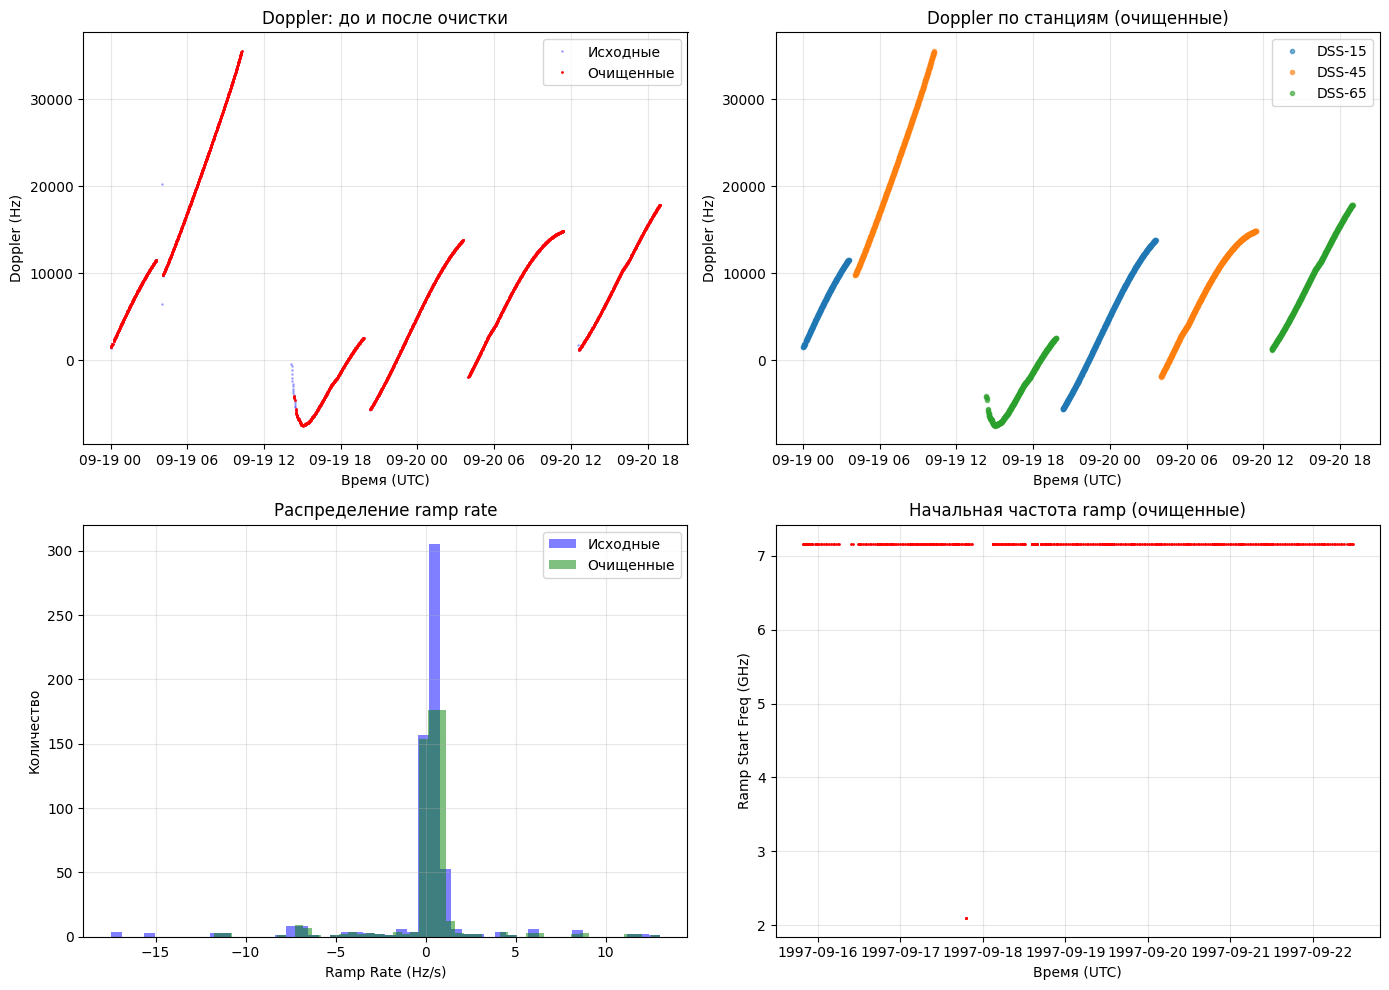

In [45]:
import pandas as pd
import numpy as np
from datetime import timedelta

def clean_doppler_df(df,
                     max_jump_hz=1000,
                     max_doppler_rate=3.0,
                     max_gap_min=5):
    """
    Очищает только доплеровский DataFrame.
    """
    print("="*60)
    print(" ОЧИСТКА DOPPLER")
    print("="*60)
    df_work = df.sort_values('datetime_utc').copy()
    original_count = len(df_work)
    # Технические колонки
    df_work['time_diff_sec'] = df_work['datetime_utc'].diff().dt.total_seconds()
    df_work['doppler_diff'] = df_work['doppler_hz'].diff()
    df_work['doppler_rate'] = df_work['doppler_diff'] / df_work['time_diff_sec']
    # Фильтр скачков
    mask_no_jumps = abs(df_work['doppler_diff']) <= max_jump_hz
    mask_no_jumps = mask_no_jumps.fillna(True)
    # Фильтр по скорости изменения
    mask_good_doppler_rate = abs(df_work['doppler_rate']) <= max_doppler_rate
    mask_good_doppler_rate = mask_good_doppler_rate.fillna(True)
    # Общий фильтр
    final_mask = mask_no_jumps & mask_good_doppler_rate
    df_clean = df_work[final_mask].copy()
    # Сеансы
    df_clean['time_diff_sec'] = df_clean['datetime_utc'].diff().dt.total_seconds()
    time_gaps = df_clean['time_diff_sec'] > (max_gap_min * 60)
    df_clean['session_id'] = time_gaps.cumsum()
    print(f"\n Итог: {original_count} → {len(df_clean)} записей ({100*len(df_clean)/original_count:.1f}%)")
    print(f"       {df_clean['session_id'].nunique()} сеансов")
    df_clean.drop(columns=['time_diff_sec','doppler_diff','doppler_rate'], errors='ignore', inplace=True)
    return df_clean

def clean_ramp_df(df, max_ramp_rate=15.0):
    """
    Очищает только ramp-DataFrame.
    """
    print("="*60)
    print(" ОЧИСТКА RAMP")
    print("="*60)
    df_work = df.sort_values('ramp_datetime_utc').copy()
    original_count = len(df_work)
    mask_good_ramp = df_work['ramp_rate_hz_s'].abs() <= max_ramp_rate
    mask_good_ramp = mask_good_ramp.fillna(False)
    df_clean = df_work[mask_good_ramp].copy()
    print(f"\n Итог: {original_count} → {len(df_clean)} (|ramp_rate| <= {max_ramp_rate}) ({100*len(df_clean)/original_count:.1f}%)")
    print(f"   Станций: {df_clean['ramp_station_id'].nunique()}")
    return df_clean

import matplotlib.pyplot as plt

def plot_cleaning_results_separated(orig_dopp, clean_dopp, orig_ramp, clean_ramp):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # 1. Доплер до/после
    ax = axes[0, 0]
    ax.plot(orig_dopp['datetime_utc'], orig_dopp['doppler_hz'], 'b.', alpha=0.25, ms=2, label='Исходные')
    ax.plot(clean_dopp['datetime_utc'], clean_dopp['doppler_hz'], 'r.', ms=2, label='Очищенные')
    ax.set_title('Doppler: до и после очистки')
    ax.set_xlabel('Время (UTC)')
    ax.set_ylabel('Doppler (Hz)')
    ax.legend()
    ax.grid(alpha=0.3)

    # 2. По станциям (только очищенные)
    ax = axes[0, 1]
    for station in sorted(clean_dopp['receiving_station_id'].unique()):
        sel = clean_dopp['receiving_station_id'] == station
        ax.plot(clean_dopp.loc[sel, 'datetime_utc'],
                clean_dopp.loc[sel, 'doppler_hz'], '.',
                label=f'DSS-{station}', alpha=0.6)
    ax.set_title('Doppler по станциям (очищенные)')
    ax.set_xlabel('Время (UTC)')
    ax.set_ylabel('Doppler (Hz)')
    ax.legend()
    ax.grid(alpha=0.3)

    # 3. Ramp Rate до/после
    ax = axes[1, 0]
    ax.hist(orig_ramp['ramp_rate_hz_s'].clip(-20, 20), bins=50, color='blue', alpha=0.5, label='Исходные')
    ax.hist(clean_ramp['ramp_rate_hz_s'].clip(-20, 20), bins=50, color='green', alpha=0.5, label='Очищенные')
    ax.set_title('Распределение ramp rate')
    ax.set_xlabel('Ramp Rate (Hz/s)')
    ax.set_ylabel('Количество')
    ax.legend()
    ax.grid(alpha=0.3)

    # 4. Начальная частота ramp (очищенные)
    ax = axes[1, 1]
    ax.plot(clean_ramp['ramp_datetime_utc'],
            clean_ramp['ramp_start_freq_hz']/1e9, 'r.', ms=2)
    ax.set_title('Начальная частота ramp (очищенные)')
    ax.set_xlabel('Время (UTC)')
    ax.set_ylabel('Ramp Start Freq (GHz)')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('output_data/cleaning_report_separated.png', dpi=150)
    plt.show()

doppler_df = pd.read_csv('output_data/mgs_doppler.csv', parse_dates=['datetime_utc'])
ramp_df = pd.read_csv('output_data/mgs_ramp.csv', parse_dates=['ramp_datetime_utc'])

cleaned_doppler = clean_doppler_df(doppler_df)
cleaned_ramp = clean_ramp_df(ramp_df)

plot_cleaning_results_separated(doppler_df, cleaned_doppler, ramp_df, cleaned_ramp)
cleaned_doppler.to_csv('output_data/mgs_doppler_CLEANED.csv', index=False)
cleaned_ramp.to_csv('output_data/mgs_ramp_CLEANED.csv', index=False)

In [46]:
import pandas as pd
# Загрузите ваш doppler_CLEANED.csv и выведите все названия столбцов
df = pd.read_csv('./output_data/mgs_doppler_CLEANED.csv')
print("Столбцы в doppler_CLEANED.csv:")
print(df.columns.tolist())
# Проверьте похожие названия (регистр может не совпадать)
for col in df.columns:
    if 'compression' in col.lower() or 'tc' in col.lower():
        print(f'Найден похожий столбец: {col}')

Столбцы в doppler_CLEANED.csv:
['datetime_utc', 'time_tag_seconds', 'doppler_hz', 'data_type_id', 'receiving_station_id', 'transmitting_station_id', 'ref_freq_mhz', 'compression_time', 'source_file', 'lbl_file', 'session_id']
Найден похожий столбец: datetime_utc
Найден похожий столбец: compression_time


In [47]:
# Проанализируйте свой CSV-файл
import pandas as pd
df = pd.read_csv('./output_data/mgs_doppler_CLEANED.csv')
# Сгруппируйте данные по исходному файлу и посмотрите на статистику compression_time
grouped_stats = df.groupby('source_file')['compression_time'].describe()
print(grouped_stats)
# Посмотрите, уникально ли это маленькое значение
unique_values = df['compression_time'].unique()
print(f"Уникальные значения compression_time: {unique_values[:10]}") # Выведем первые 10

              count  mean  std  min  25%  50%  75%  max
source_file                                            
7261262a.odf  352.0   5.0  0.0  5.0  5.0  5.0  5.0  5.0
7262262a.odf  295.0   5.0  0.0  5.0  5.0  5.0  5.0  5.0
7262262b.odf  120.0   5.0  0.0  5.0  5.0  5.0  5.0  5.0
7262262c.odf  139.0   5.0  0.0  5.0  5.0  5.0  5.0  5.0
7262263a.odf  281.0   5.0  0.0  5.0  5.0  5.0  5.0  5.0
7263263a.odf  617.0   5.0  0.0  5.0  5.0  5.0  5.0  5.0
7263263b.odf  119.0   5.0  0.0  5.0  5.0  5.0  5.0  5.0
7263263c.odf  244.0   5.0  0.0  5.0  5.0  5.0  5.0  5.0
Уникальные значения compression_time: [5.]
